In [1]:
import gt_func
import math
import numpy as np
import gtsam

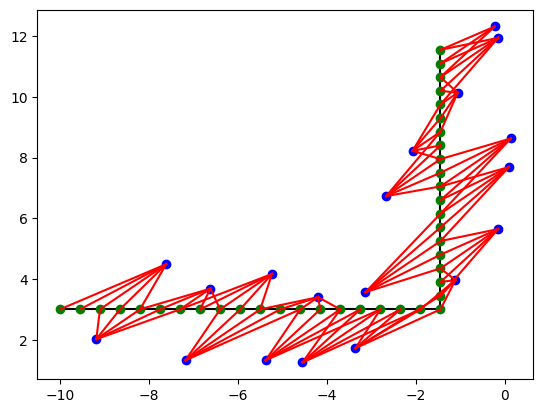

In [2]:
def get_data(batch_size, hop):
    X, Y, THETA, pose = gt_func.gt_lshape()
    LDMK = gt_func.make_landmarks(X, Y, batch_size, hop)
    range_bearing = gt_func.get_pose_landmark_edge(X, Y, LDMK, batch_size, hop)
    return X, Y, THETA, pose, LDMK, range_bearing, batch_size, hop


X, Y, THETA, pose, LDMK, range_bearing, batch_size, hop = get_data(5, 2)
gt_func.plot_pose_landmark(X, Y, LDMK, batch_size, hop)

In [3]:

def addNoise(X, Y, THETA, pose_sigma):
	xN = np.zeros(len(X)); yN = np.zeros(len(Y)); tN = np.zeros(len(THETA))
	xN[0] = X[0]; yN[0] = Y[0]; tN[0] = THETA[0]

	for i in range(1, len(X)):
		# Get T2_1
		p1 = (X[i-1], Y[i-1], THETA[i-1])
		p2 = (X[i], Y[i], THETA[i])
		T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
		T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
		T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
		del_x = T2_1[0][2]
		del_y = T2_1[1][2]
		del_theta = math.atan2(T2_1[1, 0], T2_1[0, 0])
		# Add noise
		if(i<5):
			xNoise = 0; yNoise = 0; tNoise = 0
		else: # used dx for getting noise let's see
			xNoise = 0; yNoise = 0; tNoise = 0.015
			# xNoise = 0; yNoise = 0; tNoise = normal_dist(del_theta,0,pose_sigma[2])
		del_xN = del_x + xNoise; del_yN = del_y + yNoise; del_thetaN = del_theta + tNoise
		# Convert to T2_1'
		T2_1N = np.array([[math.cos(del_thetaN), -math.sin(del_thetaN), del_xN], [math.sin(del_thetaN), math.cos(del_thetaN), del_yN], [0, 0, 1]])
		# Get T2_w' = T1_w' . T2_1'
		p1 = (xN[i-1], yN[i-1], tN[i-1])
		T1_wN = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
		T2_wN = np.dot(T1_wN, T2_1N)
		# Get x2', y2', theta2'
		x2N = T2_wN[0][2]
		y2N = T2_wN[1][2]
		theta2N = math.atan2(T2_wN[1, 0], T2_wN[0, 0])
		xN[i] = x2N; yN[i] = y2N; tN[i] = theta2N
	return (xN, yN, tN)

def add_noise_ldmk(ldmk, ldmk_sigma):
    noise_ldmk = []
    for L in ldmk:
        noise_ldmk.append([
            L[0]+ np.random.uniform(-2,2),
            L[1]+ np.random.uniform(-2,2),
        ])
    return noise_ldmk



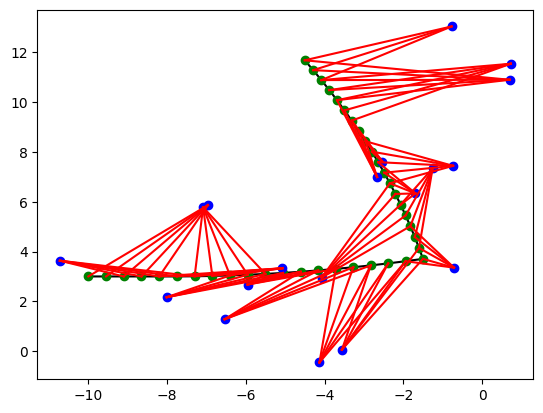

In [4]:

pose_sigma = np.array([ 1000, 1000, 1000 ]) # x, y, theta
ldmk_sigma = np.array([ 10, 10  ] )# x, y
xN, yN, tN = addNoise(X, Y, THETA, pose_sigma)
# noise_ldmk = LDMK
noise_ldmk = add_noise_ldmk(LDMK, ldmk_sigma)
gt_func.plot_pose_landmark(xN, yN, noise_ldmk, batch_size, hop)

In [5]:

def pose_symbol(i):
    	return gtsam.symbol_shorthand.X(i)

def ldmk_symbol(i):
    	return gtsam.symbol_shorthand.L(i)

def get_between_factor(p1, p2):
	T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
	T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
	T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
	dx = T2_1[0][2]
	dy = T2_1[1][2]
	dt = math.atan2(T2_1[1, 0], T2_1[0, 0])
	return gtsam.Pose2(dx, dy, dt)

def gtsam_optimisation(xN, yN, tN, noise_ldmk, range_bearing, LDMK,batch_size, hop, pose_sigma, ldmk_sigma):
	graph = gtsam.NonlinearFactorGraph()
	initial = gtsam.Values()
	print("Adding poses...")
	for idx in range(len(xN)):
		initial.insert(
			pose_symbol(idx), 
			gtsam.Pose2(xN[idx], yN[idx], tN[idx])
		)
	print("Adding odom edges...")
	priorModel = gtsam.noiseModel.Diagonal.Sigmas(pose_sigma)
	graph.add(gtsam.PriorFactorPose2(pose_symbol(0), gtsam.Pose2(xN[0], yN[0], tN[0]), priorModel))
	for idx in range(len(xN)-1):
			graph.add(gtsam.BetweenFactorPose2(
				pose_symbol(idx),
				pose_symbol(idx+1),
				get_between_factor([xN[idx],yN[idx],tN[idx]],[xN[idx+1],yN[idx+1],tN[idx+1]]),
				priorModel
			))
	print("Adding ldmk & obs. edges...")
	batch_start_idx = 0
	for idx in range(len(noise_ldmk)):
		initial.insert(
			ldmk_symbol(idx), 
			gtsam.Point2(*noise_ldmk[idx])
		)
		point_noise = gtsam.noiseModel.Diagonal.Sigmas([10,10])
		# factor = gtsam.PriorFactorPoint2(ldmk_symbol(idx),gtsam.Point2(*LDMK[idx]), point_noise)
		# graph.push_back(factor)
		final_idx = min(batch_start_idx+batch_size, len(xN))
		for j in range(batch_start_idx, final_idx):
			obs_edge_idx = j - batch_start_idx + idx*batch_size
			observation_edge = gtsam.BearingRangeFactor2D(
				pose_symbol(j),
				ldmk_symbol(idx),
				gtsam.Rot2.fromAngle(range_bearing[obs_edge_idx][1]),
				range_bearing[obs_edge_idx][0],
				gtsam.noiseModel.Diagonal.Sigmas(ldmk_sigma)
			)
			graph.add(observation_edge)
				
		batch_start_idx+=hop
	

	# print("GRAPH START : \n\n", graph)
	
	params = gtsam.LevenbergMarquardtParams()
	params.setVerbosity("Termination")  # this will show info about stopping conds
	params.setMaxIterations(500)
	optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

	result = optimizer.optimize()
	print("Optimization complete")
	print("initial error = ", graph.error(initial))
	print("final error = ", graph.error(result))

	final_x = []
	final_y = [] #orientation lite
	final_ldmk = [] 
	for idx in range(len(xN)):
		final_x.append(result.atPose2(pose_symbol(idx)).x())
		final_y.append(result.atPose2(pose_symbol(idx)).y())
	for idx in range(len(noise_ldmk)):
		final_ldmk.append(result.atPoint2(ldmk_symbol(idx)))
	return final_x, final_y, final_ldmk


Adding poses...
Adding odom edges...
Adding ldmk & obs. edges...
Optimization complete
initial error =  2.543944003501408
final error =  9.271787322804808e-06
converged
errorThreshold: 9.27179e-06 <? 0
absoluteDecrease: 1.14472934269e-07 <? 1e-05
relativeDecrease: 0.0121957980211 <? 1e-05
iterations: 12 >? 500


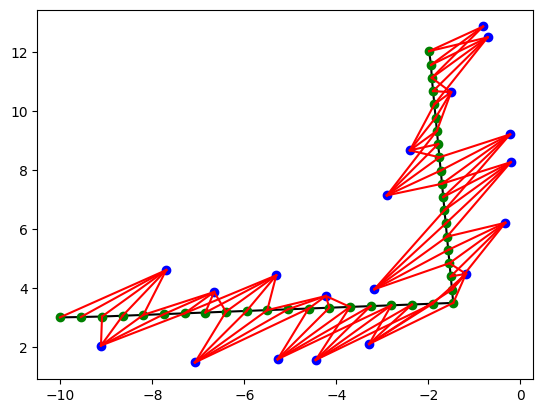

In [6]:

final_x, final_y, final_ldmk = gtsam_optimisation(xN, yN, tN, noise_ldmk,range_bearing, LDMK, batch_size, hop, pose_sigma, ldmk_sigma)
gt_func.plot_pose_landmark(final_x, final_y, final_ldmk, batch_size, hop)

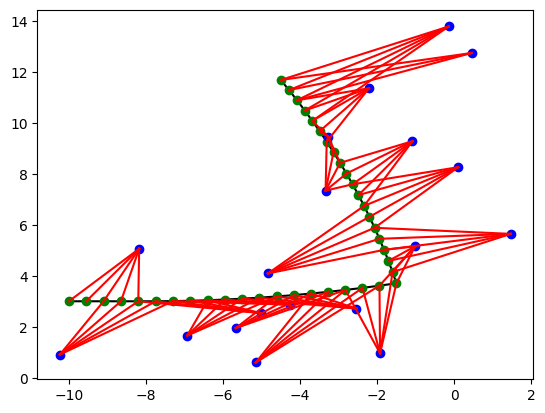

Adding poses...
Adding odom edges...
Adding ldmk & obs. edges...
Optimization complete
initial error =  0.9409401795166774
final error =  0.034800329488654684
converged
errorThreshold: 0.0348003294887 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 6 >? 500


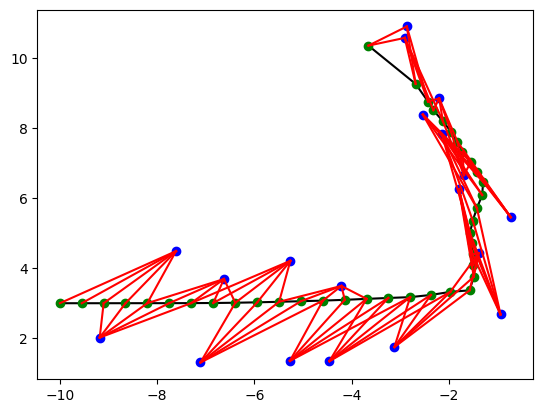

In [7]:

pose_sigma = np.array([ 10, 10, 10 ]) # x, y, theta
ldmk_sigma = np.array([ 14, 14 ] )# x, y
xN, yN, tN = addNoise(X, Y, THETA, pose_sigma)
# noise_ldmk = LDMK
noise_ldmk = add_noise_ldmk(LDMK, ldmk_sigma)
gt_func.plot_pose_landmark(xN, yN, noise_ldmk, batch_size, hop)
final_x, final_y, final_ldmk = gtsam_optimisation(xN, yN, tN, noise_ldmk,range_bearing, LDMK, batch_size, hop, pose_sigma, ldmk_sigma)
gt_func.plot_pose_landmark(final_x, final_y, final_ldmk, batch_size, hop)